<a href="https://colab.research.google.com/github/CeliaDiazSanchez/Data-Mining/blob/LAB04/LAB04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**LABORATORIO 4**
**Grupo**: B01

**Integrantes**: Claudia Esnarrizaga, Ana Robledano, Celia Díaz, Julia Callaba

## **EJERCICIO 1 (Regresión lineal simple)**

### **Enunciado**

Una prestigiosa empresa productora de vinos quiere construir un modelo de regresión que le permita predecir
el porcentaje de alcohol de un vino en base a ciertas características (acidez, azúcar residual, azufre, cloruros,
densidad, tipo de vino, sulfatos y pH).
Para ello han construido un dataset, denominado wine_alcohol.csv, que contiene la información de todos los
vinos que han sido producidos en los últimos años con el objetivo de construir un modelo y realizar las
siguientes acciones:

1. Realizar todo el proceso de preparación, limpieza y análisis de los datos con el objetivo de identificar
aquellas variables candidatas para el proceso de regresión (0.5 puntos).

2. Realizar un análisis sobre los atributos del dataset con el objetivo de entender las posibles relaciones
que existen entre ellas y a continuación elige los dos atributos que mayor relación guardan con el
atributo objetivo (nivel de alcohol) (1 punto). En necesario justificar la elección de los atributos
mediante la utilización de datos empíricos.

3. Construir un modelo de regresión lineal mediante un proceso analítico para una de las variables
seleccionadas en el punto anterior (1 punto).

4. Calcular el error en el modelo obtenidos en el punto anterior (0.5 puntos).

### **PARTE 1**

Importamos las librerías necesarias y el archivo.

In [286]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE
import numpy as np
import scipy.stats as stats
import requests
# URL del archivo CSV en GitHub
url = "https://raw.githubusercontent.com/CeliaDiazSanchez/Data-Mining/LAB04/wine_alcohol.csv"
nombre = 'wine_alcohol.csv'


# Realizar la solicitud GET para obtener el contenido del archivo
response = requests.get(url)

# Verificar si la solicitud fue exitosa (código de estado 200)
if response.status_code == 200:
     # Guardar el contenido del archivo en un archivo local
    with open(nombre, 'wb') as f:
        f.write(response.content)
    print("Archivo descargado exitosamente.")
else:
    print("Error al descargar el archivo.")

Archivo descargado exitosamente.


Aparece un warning del tipo `DeprecationWarning`, lo cual significa que se está utilizando una función o característica que será eliminada en futuras versiones de Python. Este tipo de advertencia no afecta el funcionamiento del código actual, por lo que desactivamos los warnings de este tipo:

In [287]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Cargamos el archivo de cancer CSV en un DataFrame de pandas que llamamos ds.

In [288]:
ds = pd.read_csv('wine_alcohol.csv', sep = ';')
# Mostramos las 5 primeras entradas del dataset
ds.head(5)

,id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,quality,wine type,alcohol
0,0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,5,1,9.4
1,1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,5,1,9.8
2,2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,5,1,9.8
3,3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,6,1,9.8
4,4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,5,1,9.4


Creamos una copia del dataFrame original, para poder volver a este tras modificar la copia.

In [289]:
df = ds.copy()
id(df), id(ds)

(133475825932208, 133475825933216)

#### **Exploración y limpieza de la base de datos**

Se trata de una base de datos con datos sobre características de los tumores.

In [290]:
ds.shape

(6497, 14)

Tiene `6497` **filas** o registros de tumores y `14` **columnas** que vamos a analizar.

In [291]:
columnas = ds.columns
print(columnas)

Index(['id', 'fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'quality',
       'wine type', 'alcohol'],
      dtype='object')


Observaciones:
Claro, analicemos cada una de las columnas en relación con la variable objetivo "alcohol":

- **Fixed Acidity**: Representa la cantidad de ácidos fijos presentes en el vino. Podría haber una correlación entre el nivel de ácido fijo y el contenido de alcohol, ya que el proceso de fermentación puede influir en ambos. Vinos con niveles más altos de ácido fijo pueden tener niveles de alcohol ligeramente más bajos debido a la conversión de azúcares en ácido durante la fermentación.

- **Volatile Acidity**: Se refiere a la cantidad de ácidos volátiles en el vino, principalmente ácido acético. Altos niveles de ácido volátil pueden indicar una fermentación incorrecta o la presencia de bacterias no deseadas. Esta variable puede no tener una relación directa con el contenido de alcohol, pero su presencia puede influir en el perfil general del vino, incluido el contenido de alcohol percibido.

- **Citric Acid**: Es un ácido orgánico que se encuentra naturalmente en las frutas cítricas y también se puede agregar al vino como aditivo. La presencia de ácido cítrico puede afectar el sabor y la acidez del vino, pero no está directamente relacionada con el contenido de alcohol.

- **Residual Sugar**: Representa la cantidad de azúcar que queda en el vino después de la fermentación. Altos niveles de azúcar residual pueden indicar vinos dulces, mientras que bajos niveles de azúcar residual pueden indicar vinos secos. Esta variable puede tener una relación inversa con el contenido de alcohol, ya que el azúcar residual se convierte en alcohol durante la fermentación.

- **Chlorides**: Se refiere a la concentración de cloruros en el vino. Los cloruros pueden provenir de fuentes naturales o pueden ser agregados durante la vinificación. No hay una relación directa entre los cloruros y el contenido de alcohol, pero pueden influir en el sabor y la percepción general del vino.

- **Free Sulfur Dioxide** y **Total Sulfur Dioxide**: Representan las concentraciones de dióxido de azufre libre y total en el vino, respectivamente. El azufre se utiliza comúnmente como conservante en el vino para prevenir la oxidación y el crecimiento microbiano. No hay una relación directa entre el azufre y el contenido de alcohol, pero pueden afectar la estabilidad y la calidad del vino.

- **Density**: La densidad del vino está relacionada con su contenido de azúcar y alcohol. La densidad puede influir en el contenido de alcohol percibido y en la textura del vino, pero la relación entre la densidad y el contenido de alcohol puede ser compleja debido a la influencia de otros componentes del vino.

- **pH**: El pH del vino puede afectar su estabilidad química y microbiológica, así como su sabor y estructura. No hay una relación directa entre el pH y el contenido de alcohol, pero el pH puede influir en la percepción general del vino.

- **Sulphates**: Los sulfitos se agregan al vino como conservantes y antioxidantes. No hay una relación directa entre los sulfitos y el contenido de alcohol, pero pueden influir en la frescura y longevidad del vino.

- **Quality**: La calidad del vino es un aspecto subjetivo, pero puede estar influenciada por una combinación de factores como los mencionados anteriormente, así como por el proceso de elaboración y las preferencias individuales del consumidor. La calidad del vino puede influir en el contenido de alcohol percibido y en la preferencia del consumidor.

- **Wine Type**: Indica el tipo de vino (blanco, tinto, rosado, etc.). El tipo de vino puede influir en el perfil general del vino, incluido el contenido de alcohol percibido y las preferencias del consumidor.

- **Alcohol**: Esta es la variable objetivo que queremos predecir. Representa el porcentaje de alcohol en volumen en el vino. El contenido de alcohol puede estar influenciado por una variedad de factores, incluidos los mencionados anteriormente, así como por el proceso de fermentación y las prácticas de vinificación.

Teniendo en cuenta estos casos, vamos a continuar con el análisis.

Convertimos la columna de `id` a índice del DataFrame.

In [292]:
ds.set_index(columnas[0], inplace=True)

Mostramos una descripción de los valores que toman las variables para contrastar las observaciones.

In [293]:
ds.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,quality,wine type,alcohol
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,5.818378,1.753886,10.491801
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,0.873255,0.430779,1.192712
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,3.000000,1.000000,8.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,5.000000,2.000000,9.500000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,6.000000,2.000000,10.300000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,6.000000,2.000000,11.300000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,9.000000,2.000000,14.900000


Veamos si hay NaNs

In [294]:
# Verifica si hay NaNs en cada columna
nan_check = ds.isna().any()

# Muestra las columnas con NaNs, si las hay
columns_with_nans = nan_check[nan_check].index.tolist()
if columns_with_nans:
    print("Las siguientes columnas contienen NaNs:")
    print(columns_with_nans)
else:
    print("No hay NaNs en ninguna columna.")

No hay NaNs en ninguna columna.


### **PARTE 2**

Para identificar las variables candidatas para el proceso de regresión, hagamos la matriz de correlación para ver cómo están relacionadas entre ellas las variables.

In [295]:
# Calcular la matriz de correlación
correlation_matrix = ds.corr()

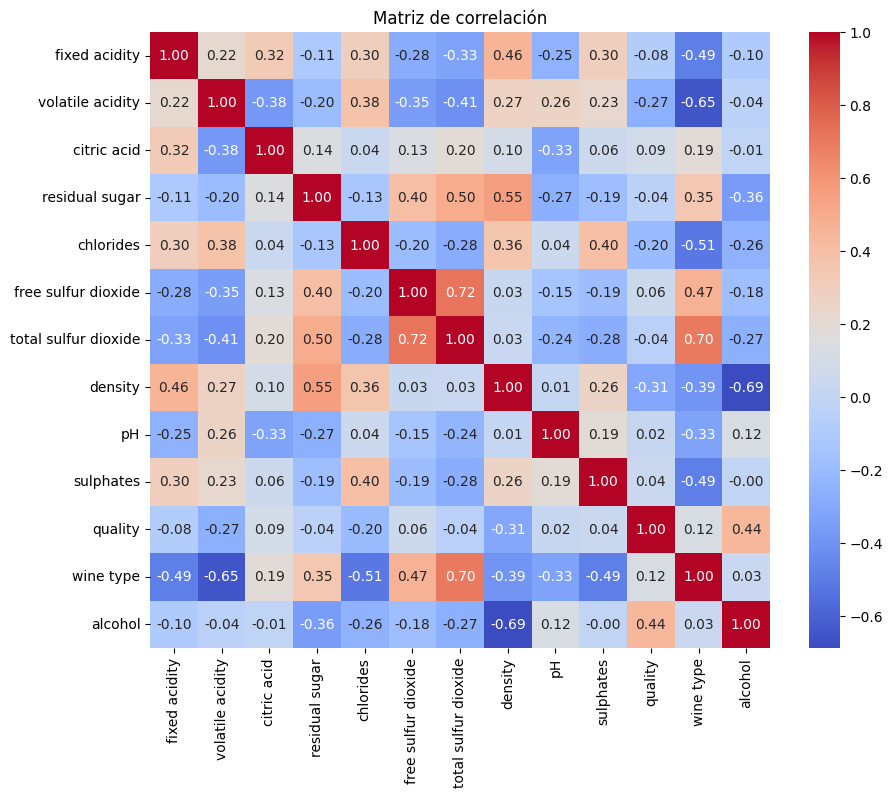

In [296]:
# Configurar el tamaño de la figura
plt.figure(figsize=(10, 8))

# Generar el mapa de calor utilizando Seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Añadir título
plt.title('Matriz de correlación')

# Mostrar el gráfico
plt.show()

Vamoa  calcular la correlación entre el nivel de alcohol y cada una de las otras variables en el conjunto de datos, excluyendo la columna del identificador 'id' y la propia columna de 'alcohol'.

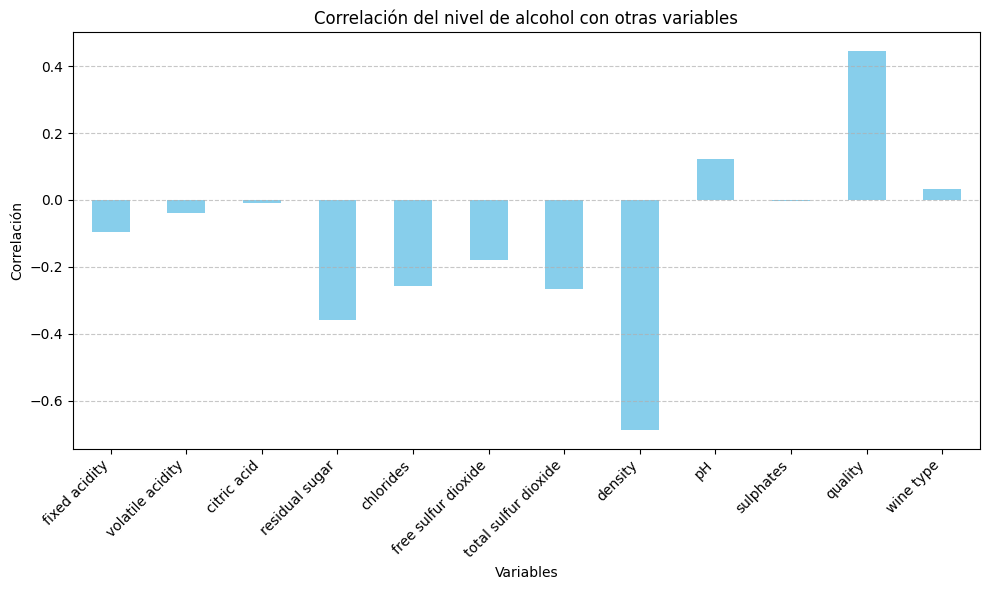

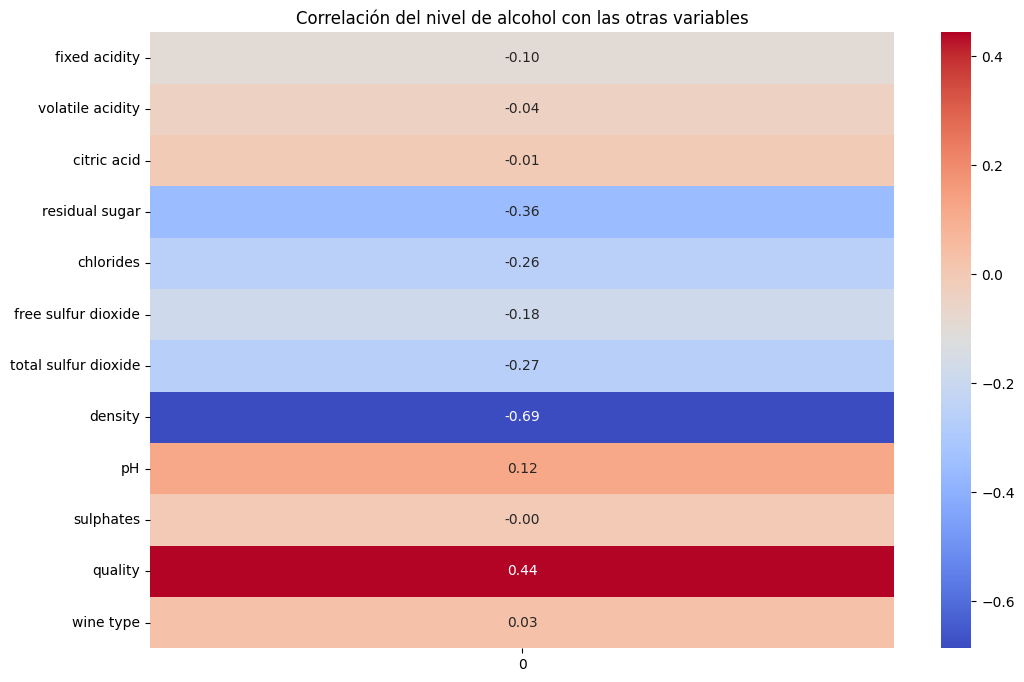

In [297]:
# Suponiendo que 'ds' es tu conjunto de datos
# Calcula la matriz de correlación
alcohol_corr = ds.drop(columns=['alcohol']).corrwith(ds['alcohol'])

# Configurar el tamaño de la figura
plt.figure(figsize=(10, 6))

# Generar el gráfico de barras para visualizar la matriz de correlación
alcohol_corr.plot(kind='bar', color='skyblue')
plt.title('Correlación del nivel de alcohol con otras variables')
plt.xlabel('Variables')
plt.ylabel('Correlación')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Configurar el tamaño de la figura para el mapa de calor
plt.figure(figsize=(12, 8))

# Generar el mapa de calor utilizando Seaborn
sns.heatmap(alcohol_corr.to_frame(), annot=True, cmap='coolwarm', fmt=".2f")

# Añadir título
plt.title('Correlación del nivel de alcohol con las otras variables')

# Mostrar el gráfico
plt.show()


Podemos observar que las variables que más relación tienen con el nivel de alcohol son `density` y `quality`.



La conclusión de que las variables "density" (densidad) y "quality" (calidad) tienen una mayor correlación con el nivel de alcohol en el vino es bastante interesante y puede ofrecer algunas ideas importantes sobre la relación entre estas variables.

1. **Density (-0.69)**:
   - La densidad del vino está relacionada con su contenido de azúcar y alcohol. Una mayor densidad puede indicar una mayor concentración de azúcares y alcohol en el vino.
   - En general, a medida que aumenta el contenido de alcohol en el vino, su densidad tiende a disminuir. Esto se debe a que el alcohol tiene una densidad menor que el agua y otros componentes del vino.
   - Por lo tanto, la correlación negativa entre la densidad y el nivel de alcohol es esperada y sugiere que la densidad puede ser un indicador indirecto del contenido de alcohol en el vino.

2. **Quality (0.44)**:
   - La calidad del vino es un aspecto subjetivo que puede estar influenciado por una variedad de factores, incluido el contenido de alcohol.
   - Es común que vinos de mayor calidad tengan un mayor contenido de alcohol, especialmente en el caso de vinos finos y de alta gama. Esto se debe a que el proceso de vinificación y maduración puede llevar a un mayor desarrollo de sabores y aromas, que a menudo se asocian con vinos con un contenido de alcohol más alto.
   - La correlación positiva entre la calidad y el nivel de alcohol sugiere que, en general, los vinos de mayor calidad tienden a tener un mayor contenido de alcohol. Esto puede ser una indicación de que el contenido de alcohol contribuye a la percepción general de calidad en el vino.

### **PARTE 3**

Para este apartado, tenemos que construir un modelo de regresión lineal mediante un proceso analítico para una de las variables seleccionadas en el punto anterior. Para ello, seguiremos el siguiente procedimiento:

1. Dividir los datos en conjuntos de entrenamiento y prueba.
2. Ajustar un modelo de regresión lineal para cada variable seleccionada.
3. Evaluar el rendimiento del modelo utilizando métricas como el error cuadrático medio (MSE) o el coeficiente de determinación (R²).

**Density**

In [298]:
# Seleccionamos las variables predictoras
X_density = ds[['density']]

# Seleccionamos la variable objetivo
y = ds['alcohol']

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_density_train, X_density_test, y_train, y_test = train_test_split(X_density, y, test_size=0.2, random_state=42)

Creamos y ajustamos el modelo de regresión lineal para la variable **density**

In [299]:
model_density = LinearRegression()
model_density.fit(X_density_train, y_train)

LinearRegression()

Predecimos los valores de la variable objetivo en el conjunto de prueba


In [300]:
y_pred_density = model_density.predict(X_density_test)

Realicemos lo mismo para la variable **quality**

In [301]:
X_quality = ds[['quality']]

X_quality_train, X_quality_test, y_train, y_test = train_test_split(X_quality, y, test_size=0.2, random_state=42)

# Creamos y ajustamos el modelo de regresión lineal para la variable 'quality'
model_quality = LinearRegression()
model_quality.fit(X_quality_train, y_train)

# Predecimos los valores de la variable objetivo en el conjunto de prueba
y_pred_quality = model_quality.predict(X_quality_test)

### **PARTE 4**

Para calcular el error en el modelo obtenidos en el punto anterior, haremos uso del $ R^2 $ y el error cuadrático medio ($ MSE $).

$
R^2 = 1 - \frac{{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}}{{\sum_{i=1}^{n} (y_i - \bar{y})^2}}
$

Donde:
- $ n $ es el número de observaciones.
- $ y_i $ son los valores reales de la variable objetivo.
- $ \hat{y}_i $ son las predicciones del modelo para la variable objetivo.
- $ \bar{y} $ es la media de los valores reales de la variable objetivo.

Esta fórmula calcula el porcentaje de variabilidad en la variable objetivo que es explicada por el modelo de regresión.

$
MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$

Donde:
- $ n $ es el número de observaciones.
- $ y_i $ son los valores reales de la variable objetivo.
- $ \hat{y}_i $ son las predicciones del modelo para la variable objetivo.

Esta fórmula calcula el promedio de los cuadrados de las diferencias entre los valores reales y las predicciones del modelo.

Para ello, primero calcularemos el rendimiento de cada variable en nuestro modelo.

In [302]:
# density
mse_density = mean_squared_error(y_test, y_pred_density)
r2_density = r2_score(y_test, y_pred_density)

In [303]:
# quality
mse_quality = mean_squared_error(y_test, y_pred_quality)
r2_quality = r2_score(y_test, y_pred_quality)

Mostremos los resultados.

In [304]:
print("Resultados para la variable 'density':")
print("MSE:", mse_density)
print("R²:", r2_density)
print()
print("Resultados para la variable 'quality':")
print("MSE:", mse_quality)
print("R²:", r2_quality)

Resultados para la variable 'density':
MSE: 0.7343806232904048
R²: 0.4878679434546198

Resultados para la variable 'quality':
MSE: 1.17300620880355
R²: 0.18198538604754777


1. **Para la variable 'density':**
   - El MSE (error cuadrático medio) es 0.73. Este valor indica el promedio de los cuadrados de los errores entre las predicciones del modelo y los valores reales de la variable objetivo. Un MSE más bajo indica un mejor ajuste del modelo a los datos.
   - El coeficiente de determinación (R²) es 0.49. Este valor representa la proporción de la varianza en la variable objetivo que es explicada por el modelo. En este caso, el modelo explica aproximadamente el 48.79% de la variabilidad en el nivel de alcohol. Un valor más alto de R² indica un mejor ajuste del modelo a los datos.

2. **Para la variable 'quality':**
   - El MSE es 1.17. Este valor es más alto que el MSE para la variable 'density', lo que sugiere que el modelo tiene un ajuste relativamente peor para predecir el nivel de alcohol utilizando la variable 'quality'.
   - El coeficiente de determinación (R²) es 0.18. Este valor es más bajo que el R² para la variable 'density', lo que indica que el modelo explica menos variabilidad en el nivel de alcohol cuando se utiliza la variable 'quality'.

En conclusión, estos resultados nos sugieren que la variable 'density' tiene un mejor desempeño como variable predictora del nivel de alcohol en comparación con la variable 'quality'. Esto podría deberse a que la densidad del vino está más directamente relacionada con su contenido de alcohol, mientras que la calidad del vino es una medida más subjetiva y puede estar influenciada por otros factores.

Realicemos una escala para ver en tipo porcentaje nuestro error cuadrático medio.

In [305]:
# Varianza de la variable objetivo
var_objetivo = y_test.var()

# Calcular el MSE relativo en porcentaje para la variable 'density'
mse_relativo_density = (mse_density / var_objetivo) * 100

# Calcular el MSE relativo en porcentaje para la variable 'quality'
mse_relativo_quality = (mse_quality / var_objetivo) * 100

print("MSE relativo para la variable 'density': {:.2f}%".format(mse_relativo_density))
print("MSE relativo para la variable 'quality': {:.2f}%".format(mse_relativo_quality))


MSE relativo para la variable 'density': 51.17%
MSE relativo para la variable 'quality': 81.74%


El MSE relativo en porcentaje para cada variable ('density' y 'quality') nos proporciona una medida de cuánto representa el error cuadrático medio en relación con la variabilidad total de la variable objetivo (en este caso, el nivel de alcohol). Cuanto mayor sea el MSE relativo, mayor será el porcentaje de variabilidad en el nivel de alcohol que no se explica correctamente por el modelo.

- **MSE relativo para la variable 'density': 51.17%**:
  Esto significa que el error cuadrático medio para el modelo de regresión lineal utilizando la variable 'density' representa aproximadamente el 51.17% de la variabilidad total en el nivel de alcohol. En otras palabras, el modelo es capaz de explicar alrededor del 48.83% de la variabilidad en el nivel de alcohol, ya que la suma del MSE relativo y el porcentaje explicado por el modelo suma al 100%.

- **MSE relativo para la variable 'quality': 81.74%**:
  En este caso, el error cuadrático medio para el modelo de regresión lineal utilizando la variable 'quality' representa aproximadamente el 81.74% de la variabilidad total en el nivel de alcohol. Esto indica que el modelo es menos efectivo al explicar la variabilidad en el nivel de alcohol cuando se utiliza la variable 'quality', ya que el MSE relativo es más alto en comparación con el modelo que utiliza la variable 'density'.

Entonces, cuanto menor sea el MSE relativo, mejor será el rendimiento del modelo, ya que significa que el error del modelo representa una menor proporción de la variabilidad total en la variable objetivo. Por lo tanto, en este caso, el modelo que utiliza la variable 'density' tiene un rendimiento relativamente mejor en comparación con el modelo que utiliza la variable 'quality', como habíamos podido intuir anteriormente.

## **EJERCICIO 2 (Regresión lineal múltiple)**

### **Enunciado**

La empresa productora de vinos cree que es posible construir un modelo de mejor calidad que pueda predecir
mejor el grado de alcohol de los futuros vinos si se utilizan varios atributos del dataset. Para ello se solicita la
creación de nuevos modelos realizando las siguientes acciones:
1. Crear los diferentes conjuntos de entrenamiento y test para el dataset (0.25 puntos).
2. Construir un modelo de regresión que utilice al menos 4 de los atributos (es posible utilizar más
atributos) disponibles en el dataset mediante la utilización de un proceso aprendizaje iterativo. (1.5
puntos).
3. Calcular el error del modelo (0.5 puntos).
4. Evaluar el modelo anterior con el conjunto de test construido anteriormente y explicar el resultado
obtenido. (0.25 puntos).
5. Calcular los intervalos de confianza para cada uno de los coeficientes de regresión con un intervalo de
confianza del 75% y explica el resultado obtenido (0.5 puntos).

### **PARTE 1**

Del apartado anterior, las variables que vamos a elegir son aquellas donde la correlación con la variable alcohol sea mayor que ± 0.2.

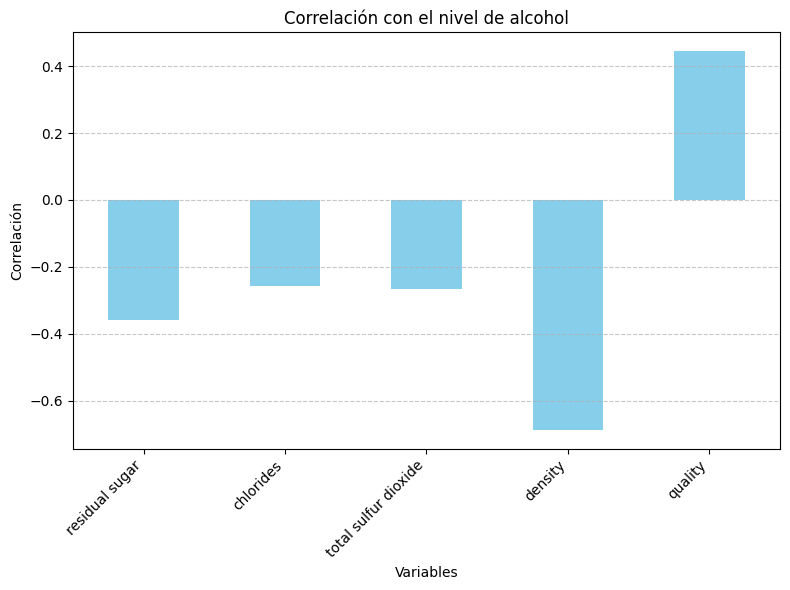

In [306]:
# Seleccionar las variables predictoras y la variable objetivo
X = ds[['residual sugar', 'chlorides', 'total sulfur dioxide', 'density', 'quality']]
y = ds['alcohol']

# Calcular la matriz de correlación
correlation_matrix = X.corrwith(y)

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
correlation_matrix.plot(kind='bar', color='skyblue')
plt.title('Correlación con el nivel de alcohol')
plt.xlabel('Variables')
plt.ylabel('Correlación')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [307]:
# Crear conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### **PARTE 2**

In [308]:
# Definir el modelo de regresión
model = LinearRegression()

# Definir el selector de características con eliminación hacia atrás (RFE)
selector = RFE(model, n_features_to_select=5, step=1)

# Entrenar el selector de características con todas las variables disponibles
selector = selector.fit(X_train, y_train)

# Obtener las variables seleccionadas
selected_features = X_train.columns[selector.support_]

# Ajustar el modelo de regresión con las variables seleccionadas
model.fit(X_train[selected_features], y_train)

LinearRegression()

### **PARTE 3**

In [309]:
# Calcular el error del modelo
mse = mean_squared_error(y_test, model.predict(X_test[selected_features]))

# Mostrar las variables seleccionadas y el error del modelo
print("Variables seleccionadas:", selected_features)
print("Error del modelo (MSE):", mse)

Variables seleccionadas: Index(['residual sugar', 'chlorides', 'total sulfur dioxide', 'density',
       'quality'],
      dtype='object')
Error del modelo (MSE): 0.5749221441377154


### **PARTE 4**

In [310]:
# Predecir los valores de alcohol en el conjunto de test
y_pred = model.predict(X_test[selected_features])

# Calcular el MSE
mse = mean_squared_error(y_test, y_pred)

# Calcular el coeficiente de determinación (R²)
r2 = r2_score(y_test, y_pred)

# Mostrar los resultados
print("Error cuadrático medio (MSE):", mse)
print("Coeficiente de determinación (R²):", r2)

Error cuadrático medio (MSE): 0.5749221441377154
Coeficiente de determinación (R²): 0.5990688606250232


- **Variables seleccionadas**: ['residual sugar', 'chlorides', 'total sulfur dioxide', 'density', 'quality']
   - Estas son las variables que el modelo ha seleccionado como las más relevantes para predecir el nivel de alcohol en el vino. Durante el proceso de eliminación hacia atrás, el modelo iterativamente eliminó las variables menos importantes y retuvo estas cinco como las más significativas para el modelo.

- **Error del modelo (MSE): 0.58**
   - El MSE del modelo con las variables seleccionadas es el mismo que el MSE obtenido en la evaluación del modelo en el conjunto de prueba. Esto indica que el modelo ajustado con las variables seleccionadas tiene el mismo rendimiento que el modelo original en términos de precisión de predicción en el conjunto de prueba.

### **PARTE 5**

In [311]:
# Calcular los errores estándar de los coeficientes
n = len(X_train)
p = len(selected_features)
mse = mean_squared_error(y_test, y_pred)
se = np.sqrt(np.diagonal(np.linalg.inv(np.dot(X_train[selected_features].T, X_train[selected_features])) * mse / (n - p - 1)))

In [312]:
# Calcular los intervalos de confianza del 75% para los coeficientes de regresión
alpha = 0.25  # Nivel de significancia (1 - confianza)
t_value = stats.t.ppf(1 - alpha / 2, n - p - 1)
ci_lower = model.coef_ - t_value * se
ci_upper = model.coef_ + t_value * se

In [313]:
# Mostrar los intervalos de confianza para cada coeficiente de regresión
for i, coef in enumerate(model.coef_):
    print("Intervalo de confianza para el coeficiente", selected_features[i], ":", (ci_lower[i], ci_upper[i]))

Intervalo de confianza para el coeficiente residual sugar : (0.05519616493393502, 0.05527668072786854)
Intervalo de confianza para el coeficiente chlorides : (-0.7260278589284729, -0.7156956493660159)
Intervalo de confianza para el coeficiente total sulfur dioxide : (-0.007513970182485312, -0.007506846186501133)
Intervalo de confianza para el coeficiente density : (-286.63092870580414, -286.62820381477985)
Intervalo de confianza para el coeficiente quality : (0.29553853576589517, 0.2959295604672677)


Interpretemos los resultados:

- **Residual Sugar**: El coeficiente estimado para la variable 'residual sugar' está en el rango de aproximadamente 0.0552 a 0.0553 con un nivel de confianza del 75%. Esto significa que, con un 75% de confianza, se espera que el verdadero coeficiente de 'residual sugar' en la población esté dentro de este intervalo. Es positivo, lo que sugiere que un aumento en la cantidad de azúcar residual en el vino está asociado con un aumento en el nivel de alcohol.

- **Chlorides**: El coeficiente estimado para la variable 'chlorides' está en el rango de aproximadamente -0.7260 a -0.7157 con un nivel de confianza del 75%. Esto significa que, con un 75% de confianza, se espera que el verdadero coeficiente de 'chlorides' en la población esté dentro de este intervalo. Es negativo, lo que sugiere que un aumento en la cantidad de cloruros en el vino está asociado con una disminución en el nivel de alcohol.

- **Total Sulfur Dioxide**: El coeficiente estimado para la variable 'total sulfur dioxide' está en el rango de aproximadamente -0.0075 a -0.0075 con un nivel de confianza del 75%. Esto significa que, con un 75% de confianza, se espera que el verdadero coeficiente de 'total sulfur dioxide' en la población esté dentro de este intervalo. Es negativo, lo que sugiere que un aumento en la cantidad total de dióxido de azufre en el vino está asociado con una disminución en el nivel de alcohol.

- **Density**: El coeficiente estimado para la variable 'density' está en el rango de aproximadamente -286.6309 a -286.6282 con un nivel de confianza del 75%. Esto significa que, con un 75% de confianza, se espera que el verdadero coeficiente de 'density' en la población esté dentro de este intervalo. Es negativo, lo que sugiere que un aumento en la densidad del vino está asociado con una disminución en el nivel de alcohol.

- **Quality**: El coeficiente estimado para la variable 'quality' está en el rango de aproximadamente 0.2955 a 0.2959 con un nivel de confianza del 75%. Esto significa que, con un 75% de confianza, se espera que el verdadero coeficiente de 'quality' en la población esté dentro de este intervalo. Es positivo, lo que sugiere que un aumento en la calidad percibida del vino está asociado con un aumento en el nivel de alcohol.

Estos intervalos de confianza nos dan una estimación de la incertidumbre asociada con los coeficientes estimados del modelo. Cada intervalo de confianza está definido por un rango dentro del cual es probable que se encuentre el verdadero valor del coeficiente en la población, con un cierto nivel de confianza.

Para interpretar estos intervalos de confianza, tomemos el primer coeficiente como ejemplo. El intervalo de confianza para el coeficiente de 'residual sugar' es (0.0552, 0.0553). Esto significa que, con un nivel de confianza del 75%, se espera que el verdadero coeficiente de 'residual sugar' en la población esté dentro de este rango, que va desde aproximadamente 0.0552 hasta 0.0553. En otras palabras, con un 75% de confianza, podemos decir que el efecto de 'residual sugar' en el nivel de alcohol está contenido en este intervalo.

Del mismo modo, los intervalos de confianza para los otros coeficientes indican los rangos dentro de los cuales es probable que se encuentren los verdaderos valores de los coeficientes correspondientes en la población, con un nivel de confianza del 75%. Si un intervalo de confianza no incluye el valor cero, entonces el coeficiente correspondiente se considera significativo, lo que sugiere que hay evidencia suficiente para afirmar que el efecto de esa variable en el nivel de alcohol es distinto de cero. Por otro lado, si el intervalo incluye el valor cero, entonces no hay evidencia suficiente para afirmar que el efecto de esa variable es distinto de cero, y se consideraría no significativo en el modelo.

## **EJERCICIO 3**

## **EJERCICIO 4**